### GhostNet implementation in keras

This is an implementation of the GhosNet in keras.<br>
Author: fvilmos, https://github.com/fvilmos<br>

In [1]:
import warnings
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import numpy as np
import utils.ghostnet as gn
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

USE_GPU = 1

if USE_GPU == 1:    
    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)

    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

Num GPUs Available:  1


In [2]:
epochs = 30
img_shape = (224,224)
batch_size = 8
width_multiplier = 0.1
head_dropout = 0.1
nr_classes = 3
samples = 5000
w,h = 224,224
img_channels = 3
obj_min_size = 15
obj_max_size = 70
nr_shape_type = 3
nr_shape_color = 6
stype_lab = ['circle','rectangle', 'triangle']
scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]


In [3]:
def toCategorical(val,size):
    '''
    transform the values to cathegorical
    '''
    s_list = [0 for _ in range(size)]
    s_list[val] = 1
    return np.array(s_list)

def generate_blur(img, iw=128,ih=128):
    """
    generate a blury background for an image
    """
    samples = (np.random.random(size=(iw,ih,3)) *1000).astype(np.ubyte)
    b_kernel = np.dot(np.random.choice([3,5,7,9,11,13,17]),np.array([1,1]))

    samples = cv2.blur(samples,tuple(b_kernel))
    img +=samples
    
    return img

# test image generator
def generate_img_with_shape(img, shape_type=0, color=(0,255,0), img_shape=(128,128), obj_size=(30,60)):
    """
    generate an image with a shape type
    0 - circle, 1 - retangle , 2 - triangle
    """

    ow = np.random.randint(obj_size[0],obj_size[1],dtype=np.uint8)
    oh = np.random.randint(obj_size[0],obj_size[1],dtype=np.uint8)
    oposx = np.random.randint(int(ow/2),img_shape[0]-ow,dtype=np.uint8)
    oposy = np.random.randint(int(oh/2),img_shape[1]-oh,dtype=np.uint8)

    if shape_type == 0:
        r = int(min(ow/2,oh/2))
        cv2.circle(img,(oposx,oposy),r,color,-1)
    elif shape_type == 1:
        cv2.rectangle(img,(oposx,oposy),(oposx+ow,oposy+oh),color,-1)
    elif shape_type == 2:
        triangle_points= np.array([[oposx,oposy],[oposx+ow,oposy],[oposx,oposy+oh]],dtype=np.int32)
        cv2.drawContours(img, [triangle_points], 0, color, -1)
        flipc = np.random.randint(-2,2,dtype=np.int8)
        img = cv2.flip(img,flipc)
    return img



def gen_traning_data(samples_nr=1000, iw=128,ih=128,obj_min=30,obj_max=60,nr_classes=3, normalize=255):
    """ 
    generate traning data - rectangles with different size, return img and position
    """
    
    img = np.zeros((samples_nr,iw,ih,3),dtype=np.float32)
    img_labels = np.zeros((samples_nr,nr_classes),dtype=np.uint8)
 
    # generate random samples
    for i in range (samples_nr):

        samples = np.zeros(shape=(iw,ih,3),dtype=np.uint8)
        
        img[i] += generate_blur(samples, iw,ih)

        shape_type = np.random.randint(0,3,dtype=np.uint8)

        # generate random between [0,5]
        clord = np.random.randint(0,6,dtype=np.uint8)
        color = colors[clord]

        img[i] = generate_img_with_shape(img[i],shape_type=shape_type, color=color) / normalize
        
        cat_val = toCategorical(shape_type,nr_classes)
        img_labels[i] = np.array(cat_val)

    return img, img_labels

Samples shape:  (8, 224, 224, 3) Labels: (8, 3)


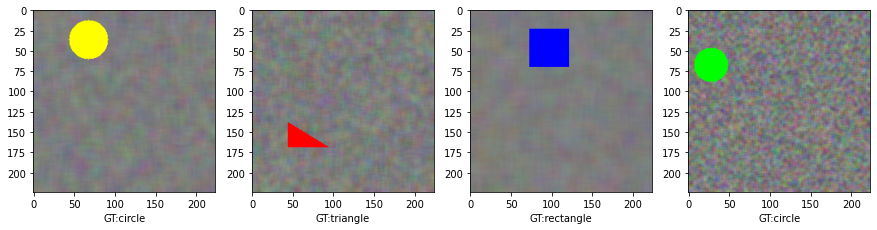

In [6]:
class DataLoader(keras.utils.Sequence):
    """
    Dataset generator
    """
    def __init__(self, batch_size, sample_nr=1000, img_size=(128,128,3), obj_min=15, obj_max=75):
        self.batch_size = batch_size
        self.sample_nr=sample_nr
        self.img_size=img_size
        self.obj_max = obj_max
        self.obj_min = obj_min
    
    def __len__(self):
        return self.sample_nr//self.batch_size
    
    def __getitem__(self, indx):
        # simplified version, generates random samples by every call
        img,labels = gen_traning_data(samples_nr= self.batch_size,iw=self.img_size[0],ih=self.img_size[1],
                                      obj_min=self.obj_min,obj_max=self.obj_max)

        return img,labels

train_data = DataLoader(batch_size,samples, obj_min=obj_min_size, obj_max=obj_max_size, img_size=(w,h))
val_data = DataLoader(batch_size,int(samples*0.2),obj_min=obj_min_size, obj_max=obj_max_size, img_size=(w,h))
tst_data = DataLoader(batch_size,int(samples*0.05),obj_min=obj_min_size, obj_max=obj_max_size, img_size=(w,h))

print ("Samples shape: ", train_data[0][0].shape, "Labels:",train_data[0][1].shape)

# show some samples
fig, axs = plt.subplots(1, 4)
plt.rcParams["figure.figsize"] = (15,4)
for i in range (4):
    sample = tst_data[0]
    data = np.expand_dims(sample[0][i],axis=0)
    gt_label = stype_lab[np.argmax(sample[1][i])]
    axs[i].set_xlabel ("GT:" + gt_label)
    axs[i].imshow(sample[0][i])

plt.show()

# Network configuration

 Block configuration and meaning: [16,16,0.25,2,3] - expansion_ratio, out_channels, use SE module, strides, kernel size

Note: custom ResNet, with parameters ~0.287 M, has ~ 0.594 G FLOPS!


Model: "ghostnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 16) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

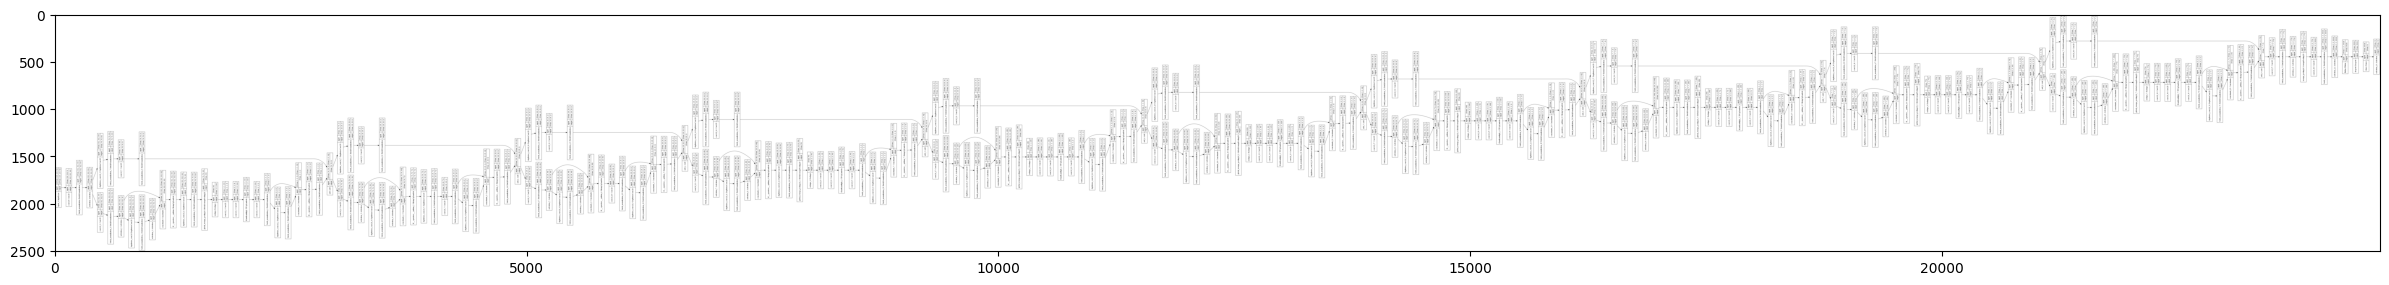

In [5]:
# ghostnet configuration
net_cfg = [{"model":"large", "conv_1":960, "conv_0":1280,"net": [
            # 1st block
            [16,16,0,1,3],
            [48,24,0,2,3],
            # 2nd block
            [72,24,0,1,3],
            [72,40,1,2,5],
            # 3rd block
            [120,40,1,1,5],
            [240,80,0,2,5],
            # 4th block
            [200,80,0,1,3],
            [184,80,0,1,3],
            [184,80,0,1,3],
            [480,112,1,1,3],
            [672,112,1,1,3],
            [672,160,1,2,3],
            # 5th block
            [960,160,0,1,5],
            [960,160,1,1,5],
            [960,160,0,1,5],
            [960,160,1,1,5],   
            ]},
            {"model": "small", "conv_1":576, "conv_0":1024, "net": [
            # 1st block
            [16,16,0.25,2,3],
            # 2nd block
            [72,24,0,2,3],
            [88,24,0,1,3],
            # 3rd block
            [96,40,0.25,2,5],
            [240,40,0.25,1,5],
            # 4th block
            [120,48,0.25,1,5],
            [144,48,0.25,1,5],
            [288,96,0.25,2,5],
            [576,96,0.25,1,5],
            [576,96,0.25,1,5],
            ]}]

class GhostNet:
    def __init__(self, input_shape, net_cfg, width_multiplier=1.0, head_size=10, head_activation='softmax', head_dropout=0.3):
        self.input_shape = input_shape
        self.width_multiplier = width_multiplier
        self.head_size = head_size
        self.head_activation = head_activation
        self.head_dropout = head_dropout
        self.net_cfg = net_cfg

    def BN_with_ReLu(self, input):
        '''
        Batch normalization + relu
        '''
        y = keras.layers.BatchNormalization()(input)
        y = keras.layers.Activation('relu')(y)
        return y

    def head(self, input):
        '''
        Classification head
        '''
        y = keras.layers.Flatten()(input)
        #y = keras.layers.Dense(100)(y)
        
        if self.head_dropout is not None:
            y = keras.layers.Dropout(self.head_dropout)(y)

        # classification layer
        y = keras.layers.Dense(self.head_size)(y)
        
        # apply activation layer
        if self.head_activation is not None:
            y = keras.layers.Activation(self.head_activation)(y)
        return y
        
    def create_model(self, model_type="large"):
        '''
        Generate the GhostNet model based on the desired configuration
        '''
        input_tensor = keras.Input(shape=self.input_shape)
        y = keras.layers.Conv2D(16,(3,3), padding="SAME", strides=(2,2))(input_tensor)
        y = self.BN_with_ReLu(y)

        # add ghost bottlenecks
        for cfg in self.net_cfg:
            if cfg['model'] == model_type:
                for val in cfg['net']:
                    y = gn.ghost_bottleneck(input=y, output=val[1] * self.width_multiplier, expansion=val[0], 
                                        strides=(val[3],val[3]), kernel_size=(val[4],val[4]), se_alpha=val[2])

                y = keras.layers.Conv2D(filters=int(cfg['conv_1']), kernel_size=(1,1), strides=(1,1), padding='SAME')(y)
                y = self.BN_with_ReLu(y)
                y = keras.layers.AveragePooling2D(pool_size=(7,7))(y)
                y = keras.layers.Conv2D(filters=int(cfg['conv_0']), kernel_size=(1,1), strides=(1,1), padding='SAME')(y)
                y = self.BN_with_ReLu(y)

        # construct the classification head
        y = self.head(y)

        # construct the model
        self.model = keras.Model(input_tensor, y, name='ghostnet')

        return self.model
            
ghost_net_obj = GhostNet(input_shape=[img_shape[0],img_shape[1],3], net_cfg=net_cfg,
                         width_multiplier=width_multiplier, head_activation='softmax', head_dropout=head_dropout, head_size=nr_classes)
# create the ghostnet model
ghost_net_model = ghost_net_obj.create_model("small")

# create the network picture
keras.utils.plot_model(ghost_net_model,to_file="info/ghostnet.png",show_shapes=True)

img = plt.imread('info/ghostnet.png')
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imsave('info/ghostnet_90ccw.png', img)

plt.figure(figsize=(30,20))
plt.imshow(img)
print (ghost_net_model.summary())

loss_fn = keras.losses.CategoricalCrossentropy()
optimizer_fn = keras.optimizers.Adam(1e-4)

# assamble the full model
ghost_net_model.compile(loss=loss_fn, optimizer=optimizer_fn,run_eagerly=False, metrics=['acc'])

### Train the GhostNet

In [6]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='ghostnet.h5',
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        monitor="loss",
        min_delta = 1e-6,
    )]

hist =[]
hist =  ghost_net_model.fit(x=train_data,validation_data=val_data,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=1)

Epoch 1/30
625/625 [==============================] - 75s 102ms/step - loss: 0.9309 - acc: 0.5492 - val_loss: 1.5726 - val_acc: 0.3640

Epoch 00001: loss improved from inf to 0.93092, saving model to ghostnet.h5
Epoch 2/30
625/625 [==============================] - 62s 99ms/step - loss: 0.5398 - acc: 0.7730 - val_loss: 0.3532 - val_acc: 0.8890

Epoch 00002: loss improved from 0.93092 to 0.53985, saving model to ghostnet.h5
Epoch 3/30
625/625 [==============================] - 62s 99ms/step - loss: 0.3307 - acc: 0.8622 - val_loss: 0.5568 - val_acc: 0.8050

Epoch 00003: loss improved from 0.53985 to 0.33072, saving model to ghostnet.h5
Epoch 4/30
625/625 [==============================] - 62s 100ms/step - loss: 0.3002 - acc: 0.8752 - val_loss: 0.3715 - val_acc: 0.9180

Epoch 00004: loss improved from 0.33072 to 0.30022, saving model to ghostnet.h5
Epoch 5/30
625/625 [==============================] - 62s 99ms/step - loss: 0.3016 - acc: 0.8770 - val_loss: 1.6828 - val_acc: 0.6590

Epoch 0

### Show model loss and accuracy

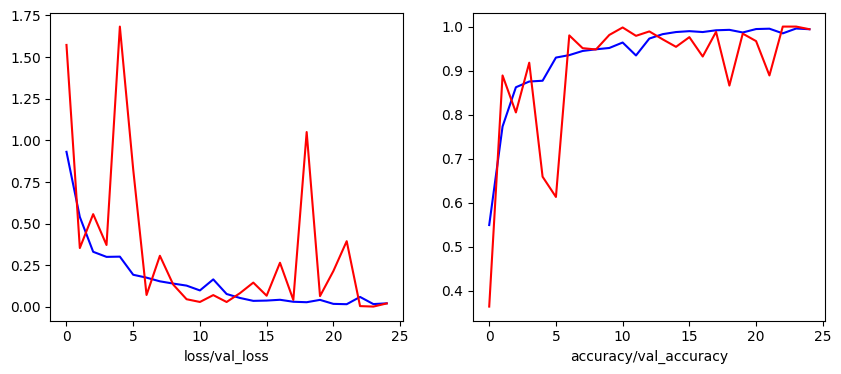

In [12]:
# draw a array of plots
fig, axs = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = (15,4)
axs[0].set_xlabel ("loss/val_loss")
axs[0].plot(hist.history['loss'], c='b')
axs[0].plot(hist.history['val_loss'], c='r')

axs[1].set_xlabel ("accuracy/val_accuracy")
axs[1].plot(hist.history['acc'], c='b')
axs[1].plot(hist.history['val_acc'], c='r')

plt.show()

### Evaluate the model

Model performace on test data...

31/31 [==============================] - 3s 33ms/step - loss: 0.2539 - acc: 0.9032
test loss, test acc: [0.253882497549057, 0.9032257795333862] 



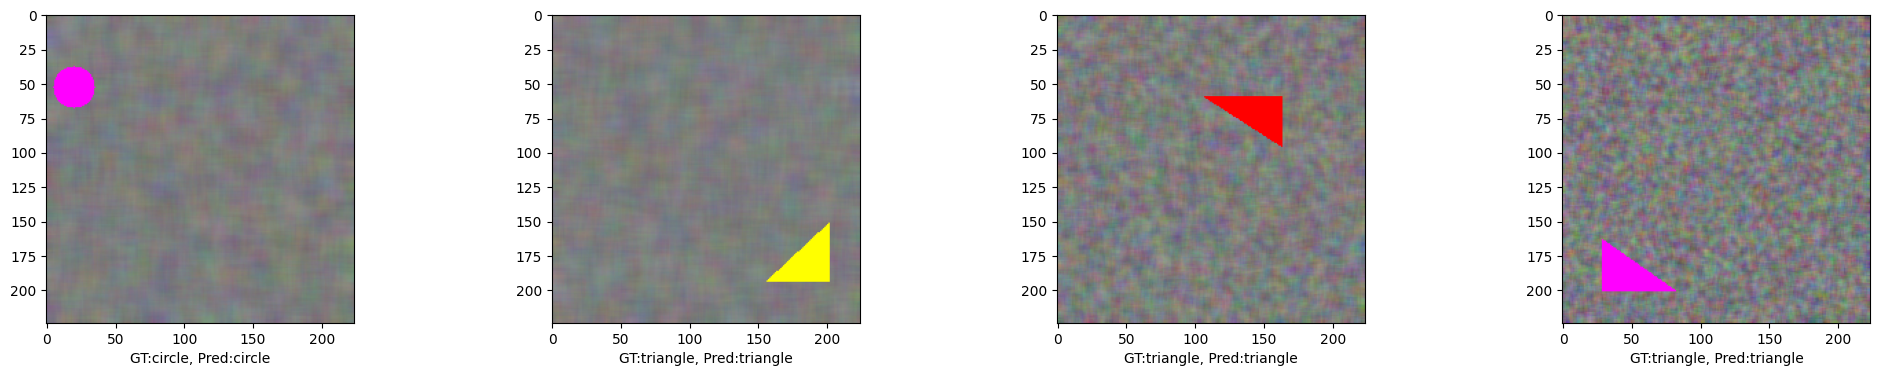

In [8]:
# load trained model
ghost_net_model = keras.models.load_model('ghostnet.h5')

print("Model performace on test data...\n")
results = ghost_net_model.evaluate(x=tst_data, batch_size=1)
print("test loss, test acc:", results, "\n")

# show some samples
fig, axs = plt.subplots(1, 4)
plt.rcParams["figure.figsize"] = (15,8)
for i in range (4):
    sample = tst_data[0]
    data = np.expand_dims(sample[0][i],axis=0)
    ret = ghost_net_model.predict(data,batch_size=1)
    y = np.zeros([3])
    y[np.argmax(ret[0])]=1
    gt_label = stype_lab[np.argmax(sample[1][i])]
    pd_label = stype_lab[np.argmax(y)]
    axs[i].set_xlabel ("GT:" + gt_label + ", Pred:" + pd_label)
    axs[i].imshow(sample[0][i])

plt.show()

### Measure model computational complexity

In [13]:
import keras_flops

flops = keras_flops.get_flops(ghost_net_model, batch_size=1)
print (f'FLOPS:, {flops/10**9:0.3} G')

FLOPS:, 0.103 G
